In [51]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
pwd

'/content'

In [54]:
df = pd.read_csv('/content/drive/MyDrive/final_df.csv')

In [55]:
df.head()

,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_pay_mean,mcare_pay_median,...,ownership_PRIVATE (FOR PROFIT)_mode_y,ownership_PRIVATE (NOT FOR PROFIT)_mode_y,ownership_STATE_mode_y,ownership_TRIBAL_mode_y,urban_rural_URBAN_mode_y,teaching_YES_mode_y,hospital_count,avg_income_2020,population_estimate_2020,Life Expectancy
0,10180,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,8.0,47740.0,173185.0,77.864183
1,10420,2018,Inpatient,breast reconstruction,8.0,19937.08375,16147.330,5692.86,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,11.0,53252.0,701449.0,76.567472
2,10500,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,0.0,0.0,0.0,1.0,0.0,4.0,45593.0,145206.0,76.615437
3,10540,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.5,0.0,0.0,1.0,0.5,2.0,42653.0,131054.0,79.088550
4,10580,2018,Inpatient,breast reconstruction,4.0,14837.26000,10420.675,4474.06,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,58601.0,878550.0,80.327023


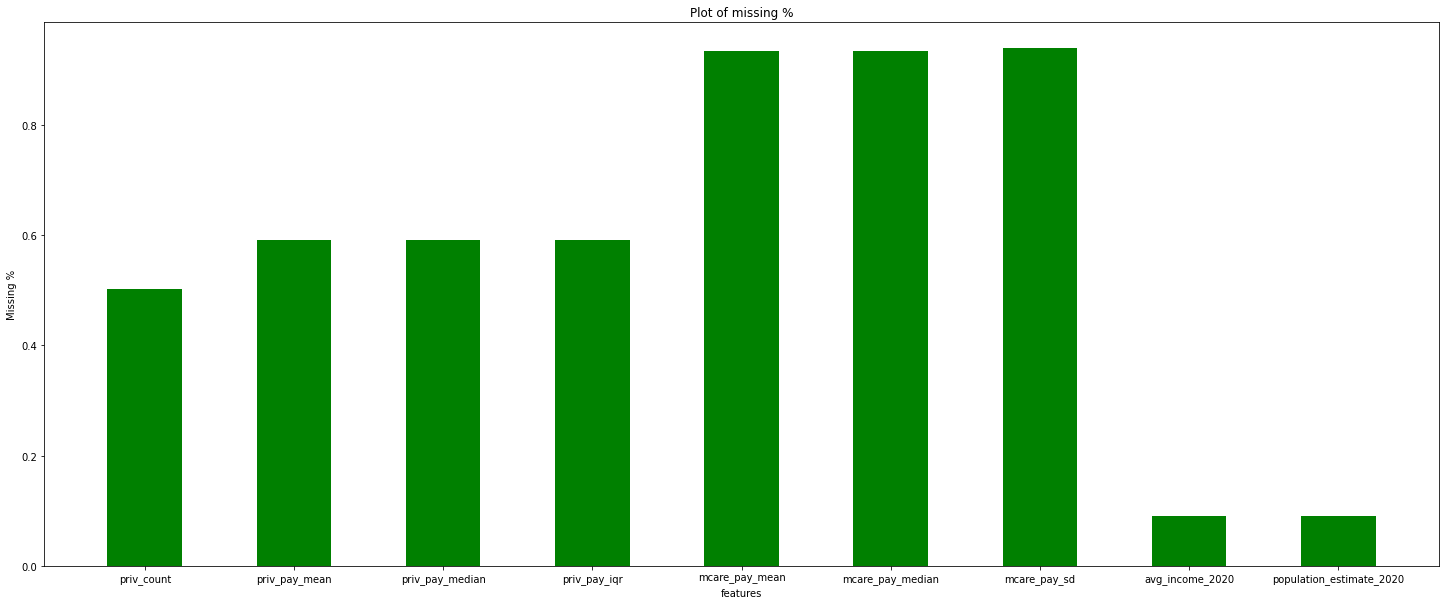

In [56]:
m = []
idx = []
x = []

for id, i in enumerate(df.columns):
  percent = df[i].isnull().sum()/len(df)
  if percent > 0.025:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [57]:
for i in df.columns:
  print(i)

msa
year
site
group
priv_count
priv_pay_mean
priv_pay_median
priv_pay_iqr
mcare_pay_mean
mcare_pay_median
mcare_pay_sd
CBSA_NAME
State
FIPS State Code
lon
lat
beds_grp_mean
Covid_payment_mean
beds_grp_greater_500_mean
ownership_FEDERAL_mean
ownership_HOSPITAL DISTRICT OR AUTHORITY_mean
ownership_LOCAL_mean
ownership_OTHER (SPECIFY)_mean
ownership_PHYSICIAN OWNERSHIP_mean
ownership_PRIVATE (FOR PROFIT)_mean
ownership_PRIVATE (NOT FOR PROFIT)_mean
ownership_STATE_mean
ownership_TRIBAL_mean
urban_rural_URBAN_mean
teaching_YES_mean
beds_grp_count
Covid_payment_count
beds_grp_greater_500_count
ownership_FEDERAL_count
ownership_HOSPITAL DISTRICT OR AUTHORITY_count
ownership_LOCAL_count
ownership_OTHER (SPECIFY)_count
ownership_PHYSICIAN OWNERSHIP_count
ownership_PRIVATE (FOR PROFIT)_count
ownership_PRIVATE (NOT FOR PROFIT)_count
ownership_STATE_count
ownership_TRIBAL_count
urban_rural_URBAN_count
teaching_YES_count
beds_grp_exists
Covid_payment_exists
beds_grp_greater_500_exists
ownership_FE

In [58]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.express as px

In [59]:
def plot_choropleth(df, i):
  state_code = pd.read_csv('/content/drive/MyDrive/us-state-ansi-fips.csv')
  df1 = df.groupby(by = 'FIPS State Code')[i].mean()
  a = state_code.merge(df1.to_frame(), left_on = ' st', right_on= 'FIPS State Code')
  a[' stusps'] = a[' stusps'].apply(lambda x: x.lstrip())

  fig = px.choropleth(a,
                    locations=' stusps',
                    color=i,
                    color_continuous_scale='spectral_r',
                    hover_name='stname',
                    locationmode='USA-states',
                    scope='usa')

  fig.show()

In [60]:
plot_choropleth(df, 'avg_income_2020')

In [61]:
plot_choropleth(df, 'Life Expectancy')

In [62]:
plot_choropleth(df, 'hospital_count')

In [63]:
# Adding Lat/Long to into haversine distance

from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

df['harvesine_distance'] = [single_pt_haversine(x, y) for x, y in zip(df.lat, df.lon)]
# Geohash.encode(df_valid.iloc[0, list(df_valid.columns).index('lat')], df_valid.iloc[0, list(df_valid.columns).index('lon')])

In [64]:
df_valid = df[~df['priv_pay_mean'].isna()]
df_valid.shape
## Nearly 60% target is missing

(54334, 105)

In [65]:
df_valid.group.nunique()
# 3 groups and proccedure types missing. Cannot be predicted.

48

In [66]:
def get_data_threshold(df, var, thres):
  print('There are {} rows and {} unique groups using {} as theshold'.format( df[df[var] > thres].shape[0], 
                                                                             df[df[var] > thres].group.nunique(), thres ) )

In [67]:
get_data_threshold(df_valid, 'priv_count', 20)
get_data_threshold(df_valid, 'priv_count', 25)
get_data_threshold(df_valid, 'priv_count', 30)
get_data_threshold(df_valid, 'priv_count', 40)
get_data_threshold(df_valid, 'priv_count', 50)
get_data_threshold(df_valid, 'priv_count', 60)

There are 8087 rows and 41 unique groups using 20 as theshold
There are 6841 rows and 39 unique groups using 25 as theshold
There are 5921 rows and 39 unique groups using 30 as theshold
There are 4680 rows and 38 unique groups using 40 as theshold
There are 3843 rows and 36 unique groups using 50 as theshold
There are 3295 rows and 31 unique groups using 60 as theshold


In [68]:
#slicing the data
df_valid = df_valid[df['priv_count'] > 50]
df_valid.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(3843, 105)

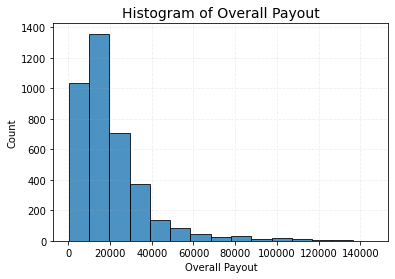

In [69]:
plt.hist(df_valid.priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

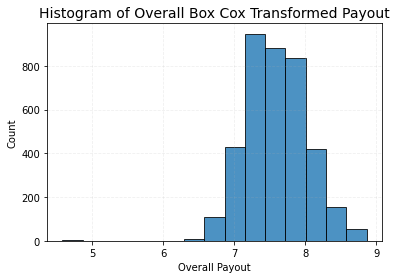

In [70]:
df_valid['bc_priv_pay_mean'] = stats.boxcox(df_valid['priv_pay_mean'])[0]

plt.hist(df_valid.bc_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Box Cox Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

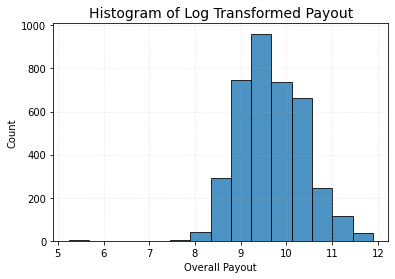

In [71]:
df_valid['log_priv_pay_mean'] = np.log(df_valid['priv_pay_mean'])

plt.hist(df_valid.log_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Log Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

In [97]:
num_features = [
'year',  
'priv_count', 
#'mcare_pay_median',
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median'
]
len(num_features)

21

In [98]:
ohe_features = ['site']
tar_enc_features = ['group', 'msa']

In [99]:
all_features = num_features + ohe_features + tar_enc_features
len(all_features)

24

### Data Visualization

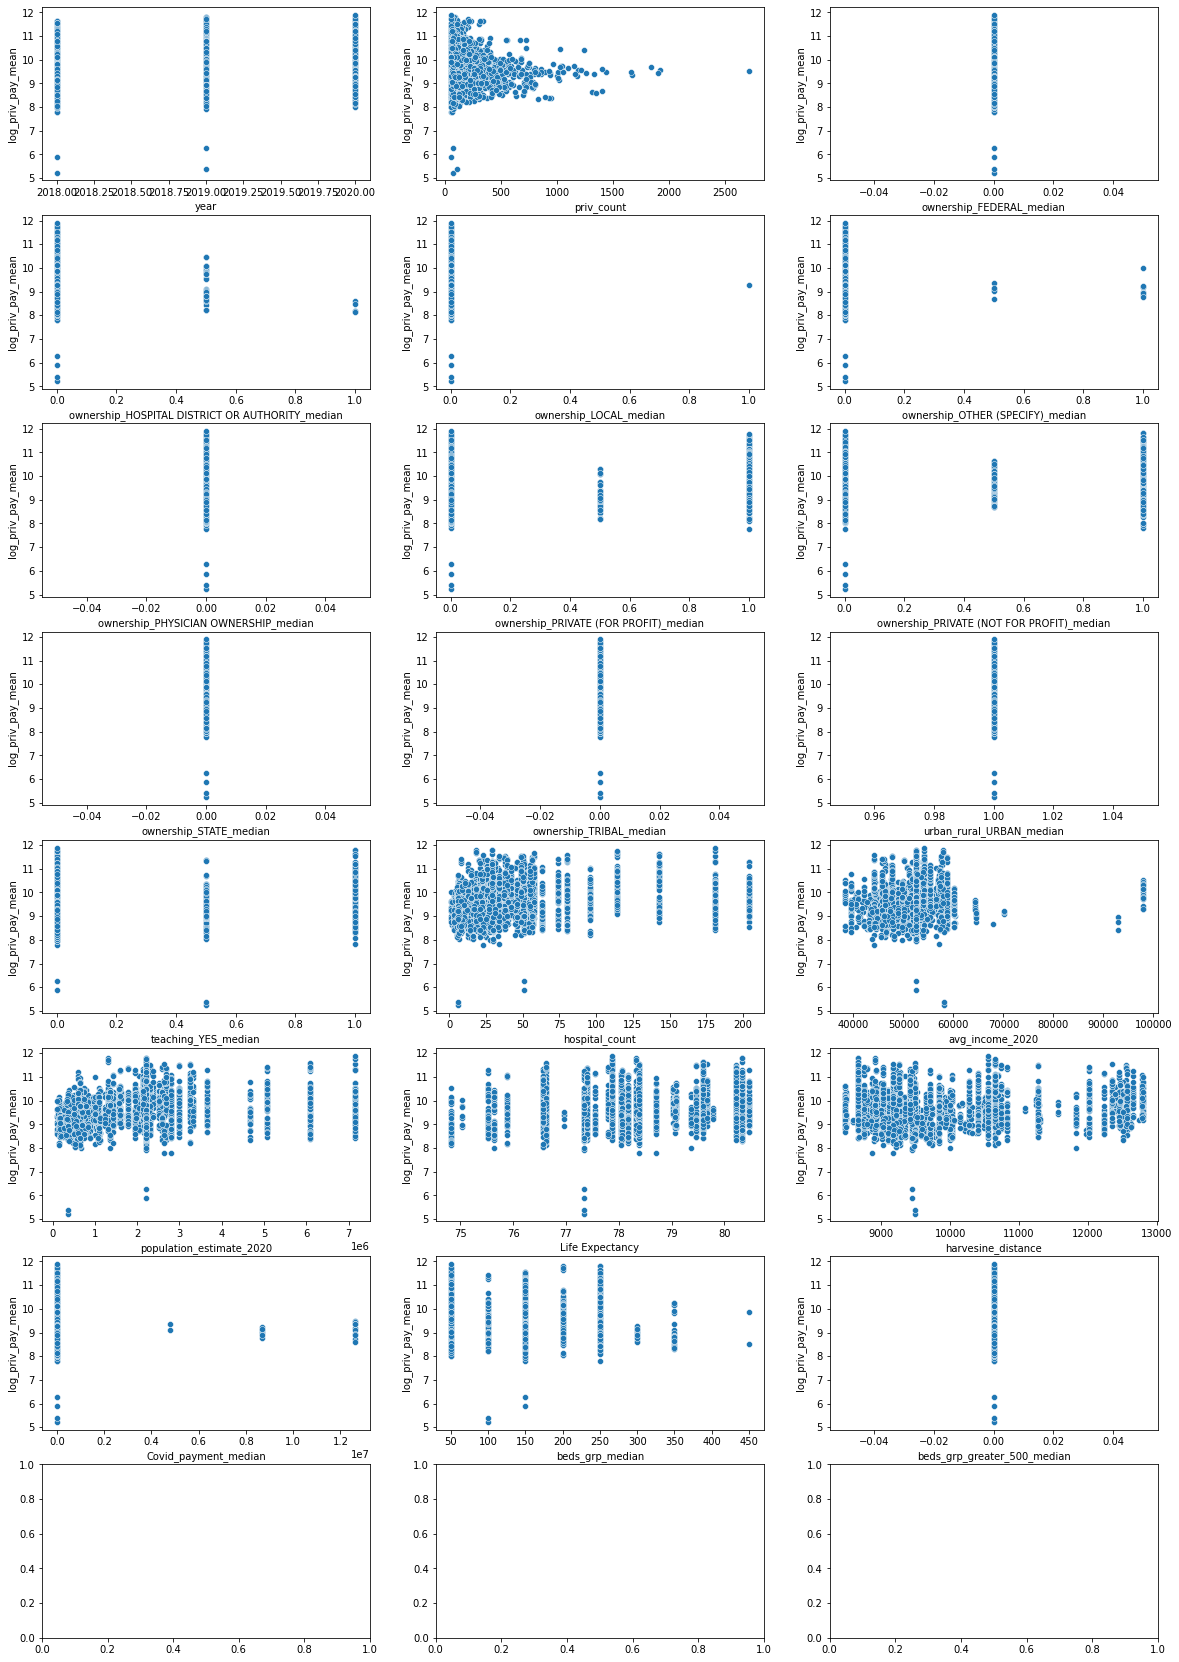

In [100]:
### Your code here
fig, ax = plt.subplots(8, 3, figsize = (20,30))

for col, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=col, y=df_valid['log_priv_pay_mean'], data = df_valid[num_features] , ax= subplot)
plt.show(fig)

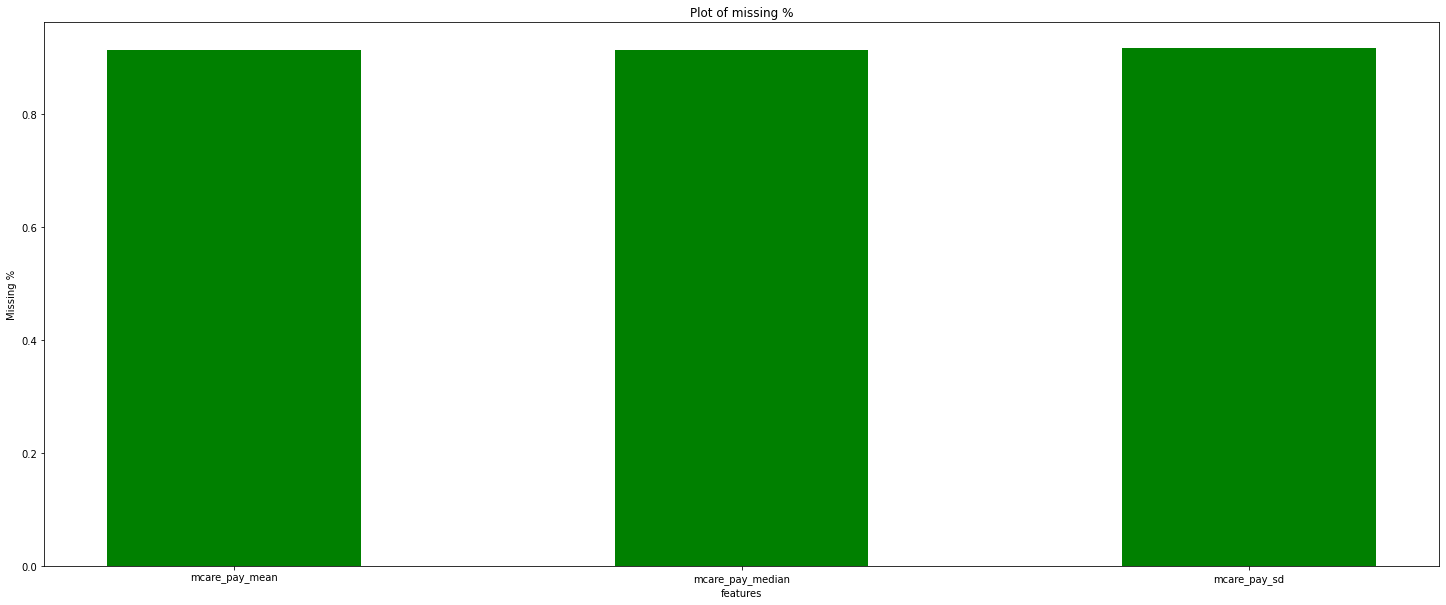

In [101]:
m = []
idx = []
x = []

for id, i in enumerate(df_valid.columns):
  percent = df_valid[i].isnull().sum()/len(df_valid)
  if percent > 0.01:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df_valid.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [102]:
df_valid[df_valid['population_estimate_2020'].isnull()][['msa', 'population_estimate_2020', 'FIPS State Code']]

,msa,population_estimate_2020,FIPS State Code


In [103]:
df_valid.isnull().sum()

msa                         0
year                        0
site                        0
group                       0
priv_count                  0
                           ..
population_estimate_2020    0
Life Expectancy             0
harvesine_distance          0
bc_priv_pay_mean            0
log_priv_pay_mean           0
Length: 107, dtype: int64

In [104]:
df_valid = df_valid[~df_valid['teaching_YES_mode_y'].isnull()]

In [105]:
df_valid['population_estimate_2020'] = df_valid['population_estimate_2020'].fillna(df_valid['population_estimate_2020'].mean())
df_valid['avg_income_2020'] = df_valid['avg_income_2020'].fillna(df_valid['avg_income_2020'].mean())

In [106]:
df_valid.isnull().sum()

msa                         0
year                        0
site                        0
group                       0
priv_count                  0
                           ..
population_estimate_2020    0
Life Expectancy             0
harvesine_distance          0
bc_priv_pay_mean            0
log_priv_pay_mean           0
Length: 107, dtype: int64

### Data Split

In [107]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import TargetEncoder
import time
from datetime import timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
df_valid_X = df_valid[all_features]
df_valid_y = df_valid['log_priv_pay_mean']

In [109]:
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.05, random_state=0)
df_valid_X_train, df_valid_X_val, df_valid_y_train, df_valid_y_val = train_test_split(df_valid_X_dev, df_valid_y_dev, test_size=0.07, random_state=0)

In [110]:
print(df_valid.shape)
print(df_valid_X_train.shape)
print(df_valid_X_val.shape)
print(df_valid_X_test.shape)

(3829, 107)
(3382, 24)
(255, 24)
(192, 24)


### Model Building

In [111]:
# #code here
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

pipe_lr_pure = make_pipeline(preprocess, LinearRegression())
pipe_fit_lr_pure = pipe_lr_pure.fit(df_valid_X_train, df_valid_y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



In [114]:
pipe_fit_lr_pure.score(df_valid_X_val, df_valid_y_val)

0.8041989689629245

In [115]:
pipe_fit_lr_pure.score(df_valid_X_test, df_valid_y_test)

0.8374525872165545

In [116]:
def mape(pred, actual):
  mape = 0
  for (p, a) in zip(pred, actual):
     mape += abs(p-a)/a
  return mape/len(pred) 

In [117]:
mape(pipe_fit_lr_pure.predict(df_valid_X_val), df_valid_y_val)

0.027595265964989978

In [118]:
mape(pipe_fit_lr_pure.predict(df_valid_X_test), df_valid_y_test)

0.027000827568361165